# Import librairies

In [34]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

from keras import optimizers
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, SimpleRNN, RepeatVector, TimeDistributed, Flatten
from keras import regularizers
from keras.layers import Dropout

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Bidirectional, LSTM
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.regularizers import l2

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import chart_studio.plotly as py
import plotly.graph_objects as go  # ou plotly.graph_objs, dependendo da versão
from plotly.offline import init_notebook_mode, iplot

# Basic packages
import datetime # manipulating date formats
import seaborn as sns # for prettier plots


# TIME SERIES
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs


# settings
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

# Set seeds to make the experiment more reproducible.
from tensorflow.random import set_seed
from numpy.random import seed
set_seed(1)
seed(1)

# Pré-processamento dos dados

* Carregando os dados
* Padronizando os dados
* Dividindo em treino, teste e validação

In [2]:
data = pd.read_csv('df_rio_interpolado.csv')

In [3]:
data.head(5)

,TEMP
0,27.73
1,27.97
2,25.70
3,26.49
4,22.42


In [4]:
scaler = MinMaxScaler()

In [5]:
# Ajustar o scaler e transformar os dados na coluna TEMP
scaled_data = scaler.fit_transform(data[['TEMP']])

In [6]:
# Salvar o scaler para uso posterior (por exemplo, para reverter a padronização)
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [7]:
# Verificar os dados padronizados
print(data.head())

    TEMP
0  27.73
1  27.97
2  25.70
3  26.49
4  22.42


## Train test split

In [8]:
# Definindo a proporção para treino, validação e teste
train_size = 0.7
valid_size = 0.15
test_size = 0.15

In [9]:
# Total de dados
total_data_len = len(scaled_data)
train_data_len = int(np.floor(total_data_len * train_size))
valid_data_len = int(np.floor(total_data_len * valid_size))
print(total_data_len)
print(train_data_len)
print(valid_data_len)


564
394
84


In [10]:
# Criando conjuntos de treinamento
train_data = scaled_data[0:train_data_len, :]
X_train, Y_train = [], []
for i in range(60, len(train_data)):
    X_train.append(train_data[i-60:i, 0])
    Y_train.append(train_data[i, 0])

X_train, Y_train = np.array(X_train), np.array(Y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

print(len(X_train))
print(len(Y_train))
print(len(train_data))

334
334
394


In [11]:
# Criando o conjunto de validação
valid_data = scaled_data[train_data_len:train_data_len + valid_data_len, :]
X_valid, Y_valid = [], []

for i in range(60, len(valid_data)):
    X_valid.append(valid_data[i-60:i, 0])
    Y_valid.append(valid_data[i, 0])

X_valid, y_valid = np.array(X_valid), np.array(Y_valid)
X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))
Y_valid = np.array(Y_valid)

print(len(X_valid))
print(len(Y_valid))
print(len(valid_data))

24
24
84


In [12]:
# Ajustando o conjunto de teste para garantir que o tamanho de X_test e Y_test sejam iguais
test_data = scaled_data[train_data_len + valid_data_len - 60:, :]  # Substitua a linha anterior
Y_test = scaled_data[train_data_len + valid_data_len:, :]  # Permanece o mesmo

X_test = []
for i in range(60, len(test_data)):
    X_test.append(test_data[i-60:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print(len(X_test))  # Agora deve corresponder ao tamanho de Y_test
print(len(Y_test))
print(len(test_data))

86
86
146


In [13]:
print(f'X_train length: {len(X_train)}')
print(f'Y_train length: {len(Y_train)}')
print(f'X_valid length: {len(X_valid)}')
print(f'y_valid length: {len(y_valid)}')
print(f'X_test length: {len(X_test)}')
print(f'Y_test length: {len(Y_test)}')

X_train length: 334
Y_train length: 334
X_valid length: 24
y_valid length: 24
X_test length: 86
Y_test length: 86


# MLP for Time Series Forecasting

* First we will use a Multilayer Perceptron model or MLP model, here our model will have input features equal to the window size.
* The thing with MLP models is that the model don't take the input as sequenced data, so for the model, it is just receiving inputs and don't treat them as sequenced data, that may be a problem since the model won't see the data with the sequence patter that it has.
* Input shape **[samples, timesteps]**.

### Selecao de Hiperparametros

In [27]:
epochs_mlp = 30
batch = 32
lr = 0.001

### Implementacao e ajuste do Modelo MLP

In [41]:
model_mlp = Sequential()
model_mlp.add(Dense(64, activation='relu', input_dim=X_train.shape[1]))
model_mlp.add(Dense(32))
model_mlp.add(Dense(1))
model_mlp.compile(loss='mean_squared_error', optimizer=optimizers.Adam())
# model_mlp.summary()

In [42]:
history_mlp = model_mlp.fit(X_train, Y_train, 
                            validation_data=(X_valid, Y_valid), 
                            epochs=epochs_mlp, 
                            verbose=2)

Epoch 1/30
11/11 - 1s - 130ms/step - loss: 0.5762 - val_loss: 0.2671
Epoch 2/30
11/11 - 0s - 7ms/step - loss: 0.1564 - val_loss: 0.0341
Epoch 3/30
11/11 - 0s - 7ms/step - loss: 0.0501 - val_loss: 0.0399
Epoch 4/30
11/11 - 0s - 7ms/step - loss: 0.0254 - val_loss: 0.0220
Epoch 5/30
11/11 - 0s - 8ms/step - loss: 0.0230 - val_loss: 0.0157
Epoch 6/30
11/11 - 0s - 9ms/step - loss: 0.0204 - val_loss: 0.0142
Epoch 7/30
11/11 - 0s - 9ms/step - loss: 0.0187 - val_loss: 0.0136
Epoch 8/30
11/11 - 0s - 6ms/step - loss: 0.0180 - val_loss: 0.0134
Epoch 9/30
11/11 - 0s - 7ms/step - loss: 0.0174 - val_loss: 0.0128
Epoch 10/30
11/11 - 0s - 8ms/step - loss: 0.0168 - val_loss: 0.0126
Epoch 11/30
11/11 - 0s - 8ms/step - loss: 0.0163 - val_loss: 0.0123
Epoch 12/30
11/11 - 0s - 14ms/step - loss: 0.0158 - val_loss: 0.0121
Epoch 13/30
11/11 - 0s - 7ms/step - loss: 0.0154 - val_loss: 0.0119
Epoch 14/30
11/11 - 0s - 8ms/step - loss: 0.0150 - val_loss: 0.0117
Epoch 15/30
11/11 - 0s - 8ms/step - loss: 0.0146 - val

### Implementacao e Ajuste do Modelo MLP com regularização

In [30]:
model_mlp_reg = Sequential()
model_mlp_reg.add(Dense(64, activation='relu', input_dim=X_train.shape[1], 
                     kernel_regularizer=regularizers.l2(0.01)))  # Regularização L2
model_mlp_reg.add(Dense(32, activation='relu', 
                     kernel_regularizer=regularizers.l2(0.01)))  # Regularização L2
model_mlp_reg.add(Dense(1))  # Saída
model_mlp_reg.compile(loss='mean_squared_error', optimizer=optimizers.Adam())
# model_mlp_reg.summary()

In [31]:
history_mlp_reg = model_mlp_reg.fit(X_train, Y_train, 
                            validation_data=(X_valid, Y_valid), 
                            epochs=epochs_mlp, 
                            verbose=2)

Epoch 1/30
11/11 - 1s - 135ms/step - loss: 1.0262 - val_loss: 0.9512
Epoch 2/30
11/11 - 0s - 7ms/step - loss: 0.9098 - val_loss: 0.8563
Epoch 3/30
11/11 - 0s - 7ms/step - loss: 0.8177 - val_loss: 0.7708
Epoch 4/30
11/11 - 0s - 7ms/step - loss: 0.7341 - val_loss: 0.6890
Epoch 5/30
11/11 - 0s - 7ms/step - loss: 0.6577 - val_loss: 0.6171
Epoch 6/30
11/11 - 0s - 7ms/step - loss: 0.5896 - val_loss: 0.5534
Epoch 7/30
11/11 - 0s - 7ms/step - loss: 0.5283 - val_loss: 0.4956
Epoch 8/30
11/11 - 0s - 7ms/step - loss: 0.4734 - val_loss: 0.4434
Epoch 9/30
11/11 - 0s - 7ms/step - loss: 0.4242 - val_loss: 0.3970
Epoch 10/30
11/11 - 0s - 7ms/step - loss: 0.3801 - val_loss: 0.3556
Epoch 11/30
11/11 - 0s - 8ms/step - loss: 0.3408 - val_loss: 0.3187
Epoch 12/30
11/11 - 0s - 6ms/step - loss: 0.3058 - val_loss: 0.2857
Epoch 13/30
11/11 - 0s - 8ms/step - loss: 0.2745 - val_loss: 0.2565
Epoch 14/30
11/11 - 0s - 7ms/step - loss: 0.2467 - val_loss: 0.2304
Epoch 15/30
11/11 - 0s - 7ms/step - loss: 0.2220 - val_

### Implementacao e ajuste do modelo MLP com Dropout

In [32]:
model_mlp_dropout = Sequential()
model_mlp_dropout.add(Dense(64, activation='relu', input_dim=X_train.shape[1]))
model_mlp_dropout.add(Dropout(0.5))  # 50% de dropout
model_mlp_dropout.add(Dense(32, activation='relu'))
model_mlp_dropout.add(Dropout(0.5))  # 50% de dropout
model_mlp_dropout.add(Dense(1))  # Saída
model_mlp_dropout.compile(loss='mean_squared_error', optimizer=optimizers.Adam())
# model_mlp_dropout.summary()



In [33]:
history_mlp_drop = model_mlp_dropout.fit(X_train, Y_train, 
                            validation_data=(X_valid, Y_valid), 
                            epochs=epochs_mlp, 
                            verbose=2)

Epoch 1/30
11/11 - 1s - 136ms/step - loss: 0.4376 - val_loss: 0.0295
Epoch 2/30
11/11 - 0s - 20ms/step - loss: 0.2128 - val_loss: 0.0265
Epoch 3/30
11/11 - 0s - 7ms/step - loss: 0.1278 - val_loss: 0.0345
Epoch 4/30
11/11 - 0s - 7ms/step - loss: 0.0975 - val_loss: 0.0288
Epoch 5/30
11/11 - 0s - 7ms/step - loss: 0.0725 - val_loss: 0.0144
Epoch 6/30
11/11 - 0s - 7ms/step - loss: 0.0844 - val_loss: 0.0170
Epoch 7/30
11/11 - 0s - 7ms/step - loss: 0.0731 - val_loss: 0.0264
Epoch 8/30
11/11 - 0s - 7ms/step - loss: 0.0732 - val_loss: 0.0235
Epoch 9/30
11/11 - 0s - 7ms/step - loss: 0.0663 - val_loss: 0.0233
Epoch 10/30
11/11 - 0s - 7ms/step - loss: 0.0562 - val_loss: 0.0266
Epoch 11/30
11/11 - 0s - 7ms/step - loss: 0.0558 - val_loss: 0.0201
Epoch 12/30
11/11 - 0s - 7ms/step - loss: 0.0530 - val_loss: 0.0241
Epoch 13/30
11/11 - 0s - 6ms/step - loss: 0.0524 - val_loss: 0.0195
Epoch 14/30
11/11 - 0s - 7ms/step - loss: 0.0456 - val_loss: 0.0189
Epoch 15/30
11/11 - 0s - 7ms/step - loss: 0.0428 - val

### Implementando e Ajustando modelo MLP com Regularização e Dropout

In [36]:
# Definição do modelo MLP com regularização e dropout
model_mlp_reg_drop = Sequential()
model_mlp_reg_drop.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.001)))
model_mlp_reg_drop.add(Dropout(0.2))  # Taxa de dropout de 20%
model_mlp_reg_drop.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model_mlp_reg_drop.add(Dropout(0.2))
model_mlp_reg_drop.add(Dense(1))  # Camada de saída
model_mlp_reg_drop.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [37]:
history_mlp_reg_drop = model_mlp_reg_drop.fit(X_train, 
                                              Y_train, 
                                              validation_data=(X_valid, Y_valid), 
                                              epochs=epochs_mlp, 
                                              batch_size=32, 
                                              verbose=1)


Epoch 1/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.4561 - mae: 0.4537 - val_loss: 0.2061 - val_mae: 0.1909
Epoch 2/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2040 - mae: 0.1685 - val_loss: 0.1812 - val_mae: 0.1355
Epoch 3/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1918 - mae: 0.1627 - val_loss: 0.1622 - val_mae: 0.0981
Epoch 4/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1799 - mae: 0.1507 - val_loss: 0.1565 - val_mae: 0.1036
Epoch 5/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1665 - mae: 0.1294 - val_loss: 0.1457 - val_mae: 0.0867
Epoch 6/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1571 - mae: 0.1230 - val_loss: 0.1413 - val_mae: 0.0881
Epoch 7/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1510 - mae: 0.1188 - val_loss: 0.1350 - val_mae: 0.0840
Epoch 8/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1482 - mae: 0.1206 - val_loss: 0.1303 - val_mae: 0.0822
Epoch 9/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1422 - ma

## Comparando os 4 modelos

In [43]:
# Função para calcular e exibir as métricas de cada modelo
def evaluate_model(model, X_test, Y_test, model_name="Modelo"):
    # Realiza as previsões no conjunto de teste
    Y_pred = model.predict(X_test)
    
    # Calcula as métricas
    mae = mean_absolute_error(Y_test, Y_pred)
    mse = mean_squared_error(Y_test, Y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((Y_test - Y_pred) / Y_test)) * 100
    accuracy = 100 - mape  # Interpretação da acurácia como "100 - MAPE"
    
    # Exibe os resultados
    print(f"\n{model_name}:")
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAPE: {mape:.4f}%")
    print(f"Acurácia: {accuracy:.2f}%")
    
    return mae, mse, rmse, mape, accuracy

# Avaliação de cada modelo no conjunto de teste
mae_standard, mse_standard, rmse_standard, mape_standard, acc_standard = evaluate_model(model_mlp, X_test, Y_test, "Modelo Padrão")
mae_reg, mse_reg, rmse_reg, mape_reg, acc_reg = evaluate_model(model_mlp_reg, X_test, Y_test, "Modelo com Regularização")
mae_dropout, mse_dropout, rmse_dropout, mape_dropout, acc_dropout = evaluate_model(model_mlp_dropout, X_test, Y_test, "Modelo com Dropout")
mae_reg_drop, mse_reg_drop, rmse_reg_drop, mape_reg_drop, acc_reg_drop = evaluate_model(model_mlp_reg_drop, X_test, Y_test, "Modelo com Regularização e Dropout")

# Comparação dos resultados (opcional)
print("\nComparação de resultados:")
print(f"Modelo Padrão - MAE: {mae_standard:.4f}, RMSE: {rmse_standard:.4f}, MAPE: {mape_standard:.4f}%, Acurácia: {acc_standard:.2f}%")
print(f"Modelo com Regularização - MAE: {mae_reg:.4f}, RMSE: {rmse_reg:.4f}, MAPE: {mape_reg:.4f}%, Acurácia: {acc_reg:.2f}%")
print(f"Modelo com Dropout - MAE: {mae_dropout:.4f}, RMSE: {rmse_dropout:.4f}, MAPE: {mape_dropout:.4f}%, Acurácia: {acc_dropout:.2f}%")
print(f"Modelo com Regularização e Dropout - MAE: {mae_reg_drop:.4f}, RMSE: {rmse_reg_drop:.4f}, MAPE: {mape_reg_drop:.4f}%, Acurácia: {acc_reg_drop:.2f}%")


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step

Modelo Padrão:
MAE: 0.0807
MSE: 0.0112
RMSE: 0.1058
MAPE: 21.5215%
Acurácia: 78.48%
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

Modelo com Regularização:
MAE: 0.0737
MSE: 0.0088
RMSE: 0.0936
MAPE: 17.7647%
Acurácia: 82.24%
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

Modelo com Dropout:
MAE: 0.1346
MSE: 0.0270
RMSE: 0.1643
MAPE: 27.4478%
Acurácia: 72.55%
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

Modelo com Regularização e Dropout:
MAE: 0.0726
MSE: 0.0085
RMSE: 0.0923
MAPE: 17.3661%
Acurácia: 82.63%

Comparação de resultados:
Modelo Padrão - MAE: 0.0807, RMSE: 0.1058, MAPE: 21.5215%, Acurácia: 78.48%
Modelo com Regularização - MAE: 0.0737, RMSE: 0.0936, MAPE: 17.7647%, Acurácia: 82.24%
Modelo com Dropout - MAE: 0.1346, RMSE: 0.1643, MAPE: 27.4478%, Acurácia: 72.55%
Modelo com Regularização e Dropout - MAE: 0.0726, RMSE: 0.0923, MAPE: 17.3661%, Acurácia: 82.63%


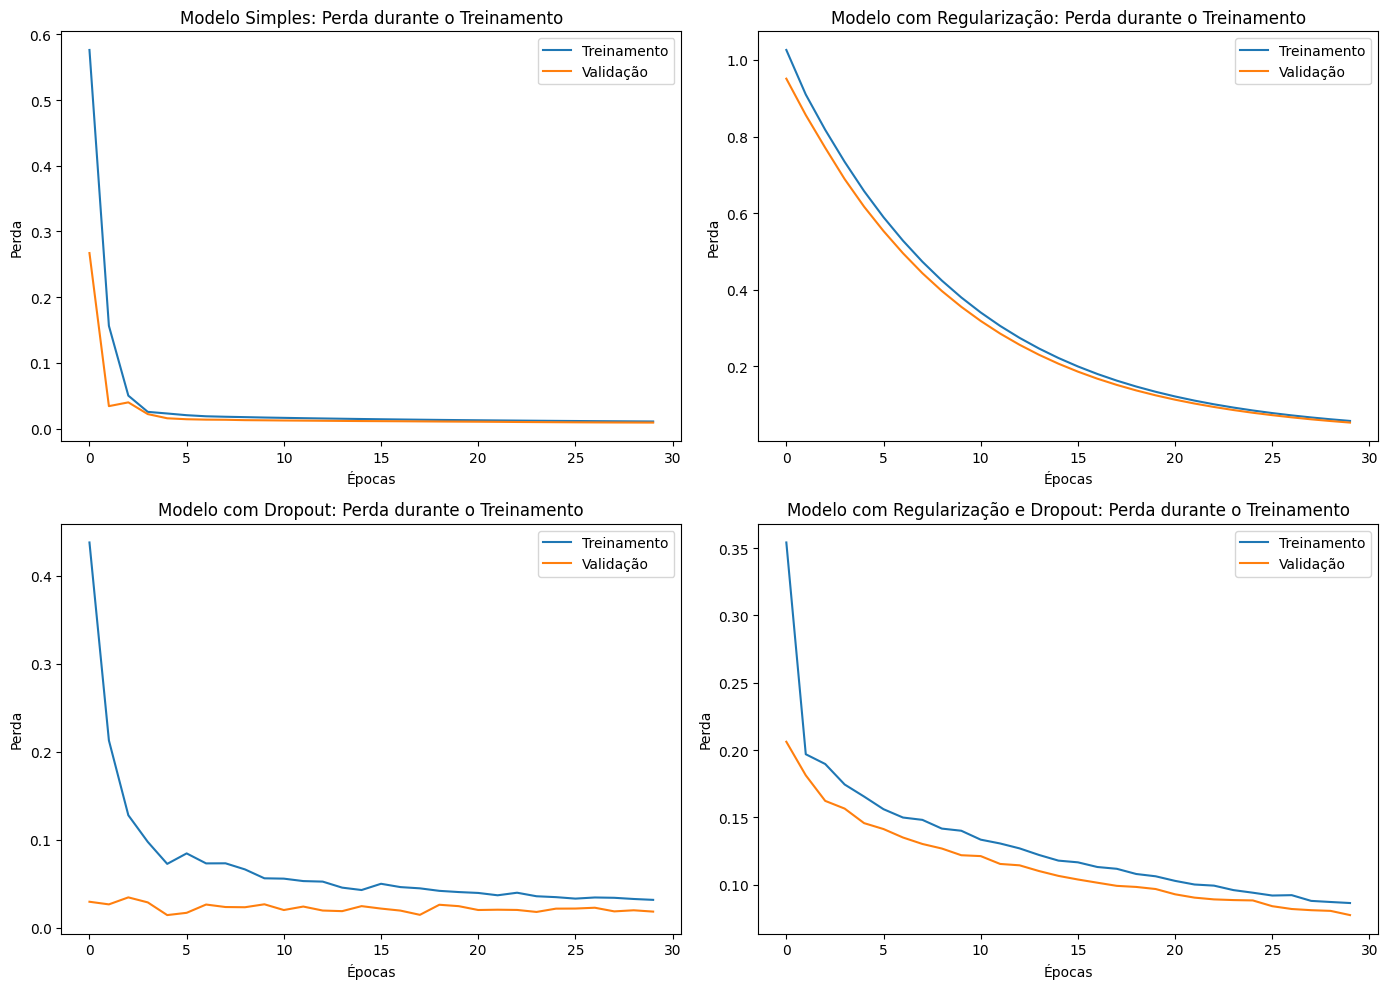

In [44]:
# Gráficos de ajuste combinado no conjunto de treinamento e validação e previsão no conjunto de teste
plt.figure(figsize=(14, 10))

# Modelo Simples
plt.subplot(2, 2, 1)
plt.plot(history_mlp.history['loss'], label='Treinamento')
plt.plot(history_mlp.history['val_loss'], label='Validação')
plt.title('Modelo Simples: Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

# Modelo com Regularização
plt.subplot(2, 2, 2)
plt.plot(history_mlp_reg.history['loss'], label='Treinamento')
plt.plot(history_mlp_reg.history['val_loss'], label='Validação')
plt.title('Modelo com Regularização: Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

# Modelo com Dropout
plt.subplot(2, 2, 3)
plt.plot(history_mlp_drop.history['loss'], label='Treinamento')
plt.plot(history_mlp_drop.history['val_loss'], label='Validação')
plt.title('Modelo com Dropout: Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

# Modelo com Regularização e Dropout
plt.subplot(2, 2, 4)
plt.plot(history_mlp_reg_drop.history['loss'], label='Treinamento')
plt.plot(history_mlp_reg_drop.history['val_loss'], label='Validação')
plt.title('Modelo com Regularização e Dropout: Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

plt.tight_layout()
plt.show()

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


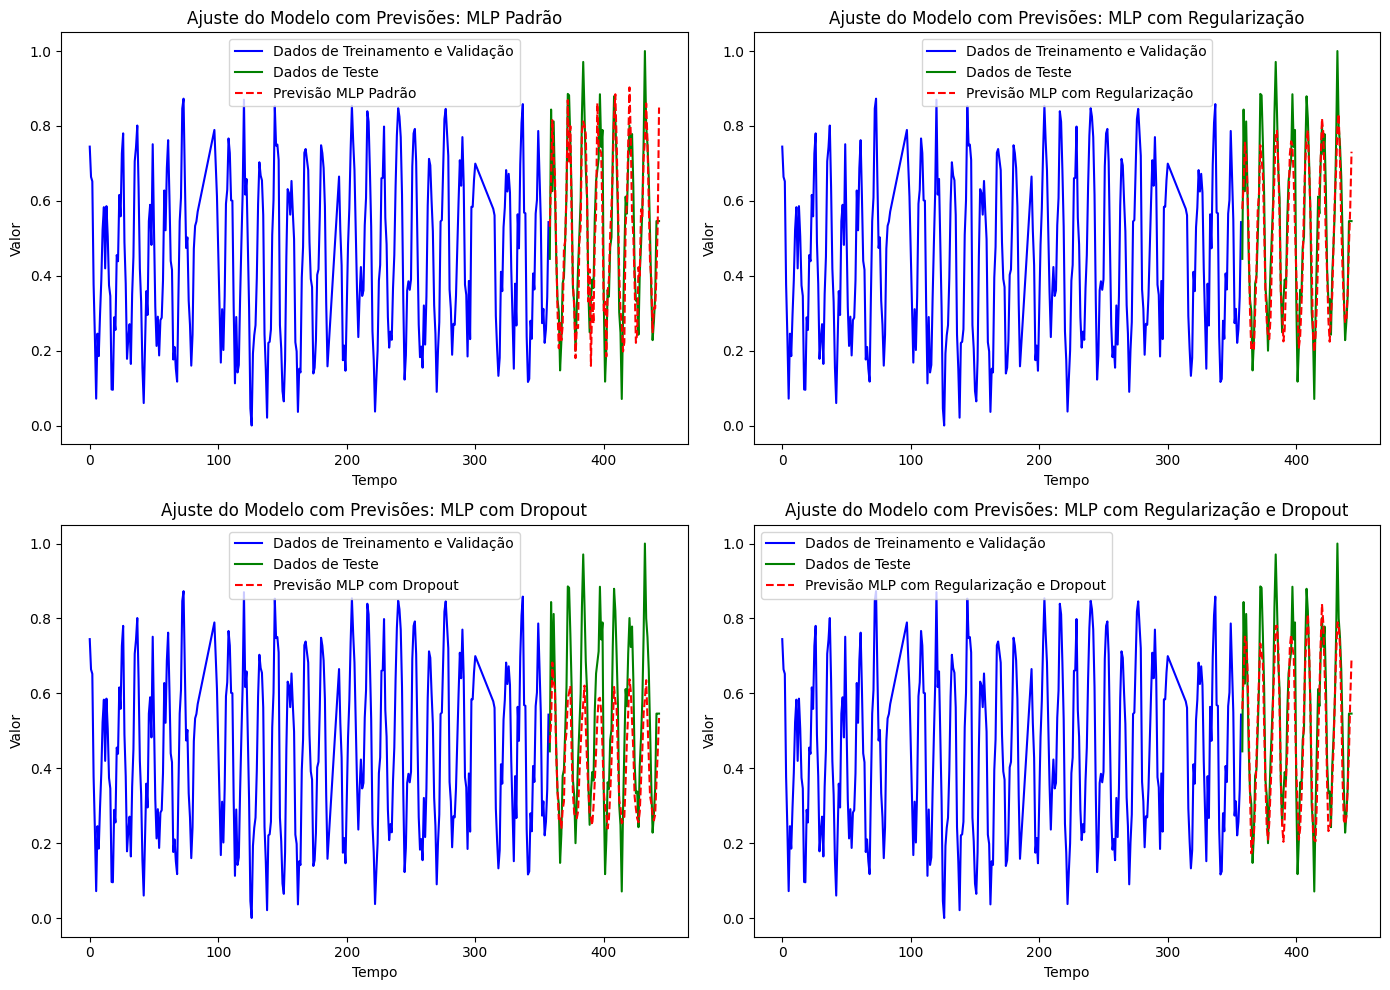

In [45]:
# Gerando previsões para cada modelo
y_pred_mlp = model_mlp.predict(X_test)
y_pred_mlp_reg = model_mlp_reg.predict(X_test)
y_pred_mlp_drop = model_mlp_dropout.predict(X_test)
y_pred_mlp_reg_drop = model_mlp_reg_drop.predict(X_test)

# Combine os dados de treino e validação em uma série para comparação visual com o conjunto de teste e previsões.
train_valid_data = np.concatenate([Y_train, Y_valid])  # Combina Y_train e Y_valid em uma série contínua

# Função para exibir os gráficos lado a lado
def plot_multiple_predictions(train_valid_data, y_test, y_pred_models, model_names):
    # Definindo o tamanho da figura e o layout (2 gráficos por linha)
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()  # Achata o array de eixos para indexação direta
    
    for idx, (y_pred, model_name) in enumerate(zip(y_pred_models, model_names)):
        ax = axes[idx]
        
        # Plot dos dados de treino e validação
        ax.plot(range(len(train_valid_data)), train_valid_data, label="Dados de Treinamento e Validação", color="blue")
        
        # Plot dos dados de teste
        ax.plot(range(len(train_valid_data), len(train_valid_data) + len(y_test)), y_test, label="Dados de Teste", color="green")
        
        # Plot das previsões
        ax.plot(range(len(train_valid_data), len(train_valid_data) + len(y_test)), y_pred, label=f"Previsão {model_name}", color="red", linestyle="--")
        
        # Configurações do gráfico
        ax.set_title(f'Ajuste do Modelo com Previsões: {model_name}')
        ax.set_xlabel("Tempo")
        ax.set_ylabel("Valor")
        ax.legend()

    # Ajusta o layout e exibe
    plt.tight_layout()
    plt.show()

# Lista com previsões e nomes dos modelos para plotar
y_pred_models = [y_pred_mlp, y_pred_mlp_reg, y_pred_mlp_drop, y_pred_mlp_reg_drop]
model_names = ["MLP Padrão", "MLP com Regularização", "MLP com Dropout", "MLP com Regularização e Dropout"]

# Chamando a função para exibir os gráficos lado a lado
plot_multiple_predictions(train_valid_data, Y_test, y_pred_models, model_names)


# CNN for Time Series Forecasting

* For the CNN model we will use one convolutional hidden layer followed by a max pooling layer. The filter maps are then flattened before being interpreted by a Dense layer and outputting a prediction.
* The convolutional layer should be able to identify patterns between the timesteps.
* Input shape **[samples, timesteps, features]**.

#### Data preprocess
* Reshape from [samples, timesteps] into [samples, timesteps, features].
* This same reshaped data will be used on the CNN and the LSTM model.

In [ ]:
#Hiperparametros
epochs = 20
batch = 32
lr = 0.001
#adam = optimizers.Adam(lr)


In [ ]:
X_train_series = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid_series = X_valid.reshape((X_valid.shape[0], X_valid.shape[1], 1))
X_test_series = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)
print('Test set shape', X_test_series.shape)

## Aplicando Modelo CNN

In [ ]:
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='relu'))
model_cnn.add(Dense(1))
model_cnn.compile(loss='mse', optimizer=optimizers.Adam())
model_cnn.summary()

In [ ]:
cnn_history = model_cnn.fit(X_train_series, Y_train, 
                            validation_data=(X_valid_series, Y_valid), 
                            epochs=epochs, 
                            verbose=2)

## Aplicando Regularização

In [ ]:
model_cnn_reg = Sequential()
model_cnn_reg.add(Conv1D(filters=64, kernel_size=2, activation='relu', 
                         kernel_regularizer=regularizers.l2(0.01),  # Regularização L2
                         input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn_reg.add(MaxPooling1D(pool_size=2))
model_cnn_reg.add(Flatten())
model_cnn_reg.add(Dense(50, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_cnn_reg.add(Dense(1))
model_cnn_reg.compile(loss='mse', optimizer=optimizers.Adam())
model_cnn_reg.summary()


In [ ]:
cnn_reg_history = model_cnn_reg.fit(X_train_series, Y_train, 
                            validation_data=(X_valid_series, Y_valid), 
                            epochs=epochs, 
                            verbose=2)

## Aplicando Dropout

In [ ]:
model_cnn_drop = Sequential()
model_cnn_drop.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn_drop.add(MaxPooling1D(pool_size=2))
model_cnn_drop.add(Dropout(0.5))  # Dropout após camada de pooling
model_cnn_drop.add(Flatten())
model_cnn_drop.add(Dense(50, activation='relu'))
model_cnn_drop.add(Dropout(0.5))  # Dropout após camada densa
model_cnn_drop.add(Dense(1))
model_cnn_drop.compile(loss='mse', optimizer=optimizers.Adam())
model_cnn_drop.summary()

In [ ]:
cnn_drop_history = model_cnn_drop.fit(X_train_series, Y_train, 
                                       validation_data=(X_valid_series, Y_valid), 
                                       epochs=epochs, 
                                       verbose=2)


## Aplicando Regularização e Dropout combinados

In [ ]:
model_cnn_regdrop = Sequential()
model_cnn_regdrop.add(Conv1D(filters=64, kernel_size=2, activation='relu', 
                             kernel_regularizer=regularizers.l2(0.01),
                             input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn_regdrop.add(MaxPooling1D(pool_size=2))
model_cnn_regdrop.add(Dropout(0.5))
model_cnn_regdrop.add(Flatten())
model_cnn_regdrop.add(Dense(50, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_cnn_regdrop.add(Dropout(0.5))
model_cnn_regdrop.add(Dense(1))
model_cnn_regdrop.compile(loss='mse', optimizer=optimizers.Adam())
model_cnn_regdrop.summary()

In [ ]:
cnn_regdrop_history = model_cnn_regdrop.fit(X_train_series, Y_train, 
                                             validation_data=(X_valid_series, Y_valid), 
                                             epochs=epochs, 
                                             verbose=2)


## Preivsao dos Modelos

In [ ]:
# Previsões
predictions_simple = model_cnn.predict(X_test)
predictions_reg = model_cnn_reg.predict(X_test)
predictions_drop = model_cnn_drop.predict(X_test)
predictions_regdrop = model_cnn_regdrop.predict(X_test)


In [ ]:
# Função para calcular MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Função para calcular MSE
def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

# Função para calcular RMSE
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Cálculo das métricas para cada modelo
metrics = {
    "Modelo Simples": {
        "MAPE": mean_absolute_percentage_error(Y_test, predictions_simple),
        "MSE": mean_squared_error(Y_test, predictions_simple),
        "RMSE": root_mean_squared_error(Y_test, predictions_simple)
    },
    "Modelo com Regularização": {
        "MAPE": mean_absolute_percentage_error(Y_test, predictions_reg),
        "MSE": mean_squared_error(Y_test, predictions_reg),
        "RMSE": root_mean_squared_error(Y_test, predictions_reg)
    },
    "Modelo com Dropout": {
        "MAPE": mean_absolute_percentage_error(Y_test, predictions_drop),
        "MSE": mean_squared_error(Y_test, predictions_drop),
        "RMSE": root_mean_squared_error(Y_test, predictions_drop)
    },
    "Modelo com Regularização e Dropout": {
        "MAPE": mean_absolute_percentage_error(Y_test, predictions_regdrop),
        "MSE": mean_squared_error(Y_test, predictions_regdrop),
        "RMSE": root_mean_squared_error(Y_test, predictions_regdrop)
    }
}

# Exibir as métricas
for model, values in metrics.items():
    print(f"{model}: MAPE={values['MAPE']:.2f}%, MSE={values['MSE']:.4f}, RMSE={values['RMSE']:.4f}")


In [ ]:
# Gráficos de perda durante o treinamento
plt.figure(figsize=(14, 10))

# Modelo Simples
plt.subplot(2, 2, 1)
plt.plot(cnn_history.history['loss'], label='Treinamento')
plt.plot(cnn_history.history['val_loss'], label='Validação')
plt.title('Modelo Simples: Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

# Modelo com Regularização
plt.subplot(2, 2, 2)
plt.plot(cnn_reg_history.history['loss'], label='Treinamento')
plt.plot(cnn_reg_history.history['val_loss'], label='Validação')
plt.title('Modelo com Regularização: Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

# Modelo com Dropout
plt.subplot(2, 2, 3)
plt.plot(cnn_drop_history.history['loss'], label='Treinamento')
plt.plot(cnn_drop_history.history['val_loss'], label='Validação')
plt.title('Modelo com Dropout: Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

# Modelo com Regularização e Dropout
plt.subplot(2, 2, 4)
plt.plot(cnn_regdrop_history.history['loss'], label='Treinamento')
plt.plot(cnn_regdrop_history.history['val_loss'], label='Validação')
plt.title('Modelo com Regularização e Dropout: Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Gráficos de predição
plt.figure(figsize=(14, 10))

# Modelo Simples
plt.subplot(2, 2, 1)
plt.plot(Y_test, label='Real', color='blue')
plt.plot(predictions_simple, label='Predito (Simples)', color='red')
plt.title('Modelo Simples')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()

# Modelo com Regularização
plt.subplot(2, 2, 2)
plt.plot(Y_test, label='Real', color='blue')
plt.plot(predictions_reg, label='Predito (Reg)', color='red')
plt.title('Modelo com Regularização')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()

# Modelo com Dropout
plt.subplot(2, 2, 3)
plt.plot(Y_test, label='Real', color='blue')
plt.plot(predictions_drop, label='Predito (Drop)', color='red')
plt.title('Modelo com Dropout')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()

# Modelo com Regularização e Dropout
plt.subplot(2, 2, 4)
plt.plot(Y_test, label='Real', color='blue')
plt.plot(predictions_regdrop, label='Predito (Reg + Drop)', color='red')
plt.title('Modelo com Regularização e Dropout')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Gráficos de ajuste no conjunto de treinamento e previsão no conjunto de teste
plt.figure(figsize=(14, 10))

# Modelo Simples
plt.subplot(2, 2, 1)
plt.plot(Y_train, label='Real (Treino)', color='blue')  # Ajuste no conjunto de treino
plt.plot(np.arange(len(Y_train), len(Y_train) + len(predictions_simple)), predictions_simple, label='Predito (Teste)', color='red')  # Previsão no conjunto de teste
plt.title('Modelo Simples: Ajuste (Treino) e Previsão (Teste)')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()

# Modelo com Regularização
plt.subplot(2, 2, 2)
plt.plot(Y_train, label='Real (Treino)', color='blue')  # Ajuste no conjunto de treino
plt.plot(np.arange(len(Y_train), len(Y_train) + len(predictions_reg)), predictions_reg, label='Predito (Teste)', color='red')  # Previsão no conjunto de teste
plt.title('Modelo com Regularização: Ajuste (Treino) e Previsão (Teste)')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()

# Modelo com Dropout
plt.subplot(2, 2, 3)
plt.plot(Y_train, label='Real (Treino)', color='blue')  # Ajuste no conjunto de treino
plt.plot(np.arange(len(Y_train), len(Y_train) + len(predictions_drop)), predictions_drop, label='Predito (Teste)', color='red')  # Previsão no conjunto de teste
plt.title('Modelo com Dropout: Ajuste (Treino) e Previsão (Teste)')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()

# Modelo com Regularização e Dropout
plt.subplot(2, 2, 4)
plt.plot(Y_train, label='Real (Treino)', color='blue')  # Ajuste no conjunto de treino
plt.plot(np.arange(len(Y_train), len(Y_train) + len(predictions_regdrop)), predictions_regdrop, label='Predito (Teste)', color='red')  # Previsão no conjunto de teste
plt.title('Modelo com Regularização e Dropout: Ajuste (Treino) e Previsão (Teste)')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Combine os dados de treino e validação em uma série para comparação visual com o conjunto de teste e previsões.
train_valid_data = np.concatenate([Y_train, Y_valid])  # Combina Y_train e Y_valid em uma série contínua

def plot_fit_with_predictions(train_valid_data, y_test, y_pred, model_name):
    plt.figure(figsize=(14, 7))
    
    # Plot dos dados de treino e validação
    plt.plot(range(len(train_valid_data)), train_valid_data, label="Dados de Treinamento e Validação", color="blue")
    
    # Plot dos dados de teste
    plt.plot(range(len(train_valid_data), len(train_valid_data) + len(y_test)), y_test, label="Dados de Teste", color="green")
    
    # Plot das previsões
    plt.plot(range(len(train_valid_data), len(train_valid_data) + len(y_test)), y_pred, label=f"Previsão {model_name}", color="red", linestyle="--")
    
    plt.title(f"Ajuste do Modelo com Previsões: {model_name}")
    plt.xlabel("Tempo")
    plt.ylabel("Valor")
    plt.legend()
    plt.show()

# Plot do ajuste e previsão para cada modelo
plot_fit_with_predictions(train_valid_data, Y_test, predictions_simple, "CNN Padrão")
plot_fit_with_predictions(train_valid_data, Y_test, predictions_reg, "CNN com Regularização")
plot_fit_with_predictions(train_valid_data, Y_test, predictions_drop, "CNN com Dropout")
plot_fit_with_predictions(train_valid_data, Y_test, predictions_regdrop, "CNN com Regularização e Dropout")

# LSTM for Time Series Forecasting

* Now the LSTM model actually sees the input data as a sequence, so it's able to learn patterns from sequenced data (assuming it exists) better than the other ones, especially patterns from long sequences.
* Input shape **[samples, timesteps, features]**.

## Pre-procesamento dos dados

In [ ]:
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequence = data[i:i+seq_length]
        label = data[i+seq_length]
        sequences.append(sequence)
        labels.append(label)
    return np.array(sequences), np.array(labels)

# Defina o comprimento da sequência
seq_length = 30  # Ajuste de acordo com sua necessidade
X_train, y_train = create_sequences(scaled_data, seq_length)


## Implementacao e Ajustei do Modelo Padrao

In [ ]:
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='tanh', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mse', optimizer=optimizers.Adam())
#model_lstm.summary()

In [ ]:
history_lstm = model_lstm.fit(X_train_series, 
                              Y_train, 
                              validation_data=(X_valid_series, Y_valid), 
                              epochs=15,
                                verbose=2)

## Implementacao e Ajuste do Modelo com Regularizacao L2

In [ ]:
model_lstm_reg = Sequential()
model_lstm_reg.add(LSTM(64, activation='tanh', kernel_regularizer=regularizers.l2(0.01), input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_lstm_reg.add(Dense(1))
model_lstm_reg.compile(optimizer='adam', loss='mse')
#model_lstm_reg.summary()


In [ ]:
# Treinamento do modelo com regularização L2
history_lstm_reg = model_lstm_reg.fit(X_train_series, 
                                      y_train, 
                                      epochs=50, 
                                      batch_size=32, 
                                      validation_split=0.2, 
                                      verbose=1)

## Implementacao e Ajuste do Modelo com Dropout

In [ ]:
model_lstm_dropout = Sequential()
model_lstm_dropout.add(LSTM(64, activation='tanh', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_lstm_dropout.add(Dropout(0.2))  # Dropout de 20%
model_lstm_dropout.add(Dense(1))
model_lstm_dropout.compile(optimizer='adam', loss='mse')
#model_lstm_dropout.summary()


In [ ]:
# Treinamento do modelo com Dropout
history_lstm_dropout = model_lstm_dropout.fit(X_train_series, 
                                              y_train, 
                                              epochs=50, 
                                              batch_size=32, 
                                              validation_split=0.2, 
                                              verbose=1)


## Implementacao e Ajuste do modelo com Regularizacao e Dropout

In [ ]:
model_lstm_reg_dropout = Sequential()
model_lstm_reg_dropout.add(
    LSTM(
        50, 
        activation='tanh', 
        kernel_regularizer=regularizers.l2(0.01),  # Regularização L2
        input_shape=(X_train_series.shape[1], X_train_series.shape[2])
    )
)
model_lstm_reg_dropout.add(Dropout(0.2))  # Dropout de 20%
model_lstm_reg_dropout.add(Dense(1))
model_lstm_reg_dropout.compile(loss='mse', optimizer='adam')
#model_lstm_reg_dropout.summary()


In [ ]:
history_lstm_reg_dropout = model_lstm_reg_dropout.fit(
    X_train_series, 
    y_train, 
    epochs=50,  # Use o mesmo número de épocas dos outros modelos
    batch_size=32, 
    validation_split=0.2
)

## Comparativo entre os modelos - Predicao e Validacao

In [ ]:
# Lista dos históricos e títulos dos modelos
histories = [history_lstm, history_lstm_reg, history_lstm_dropout, history_lstm_reg_dropout]
titles = ['LSTM Básico', 'LSTM com Regularização L2', 'LSTM com Dropout', 'LSTM com L2 e Dropout']

# Criando a figura com 2 linhas e 2 colunas
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()  # Facilita iterar sobre os eixos

# Plotando cada modelo
for i, history in enumerate(histories):
    axes[i].plot(history.history['loss'], label='Treino', color='blue')
    axes[i].plot(history.history['val_loss'], label='Validação', color='orange')
    axes[i].set_title(titles[i])
    axes[i].set_xlabel('Épocas')
    axes[i].set_ylabel('MSE')
    axes[i].legend()
    axes[i].grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# Obtendo as previsões dos quatro modelos
pred_lstm = model_lstm.predict(X_test_series)
pred_lstm_reg = model_lstm_reg.predict(X_test_series)
pred_lstm_dropout = model_lstm_dropout.predict(X_test_series)
pred_lstm_reg_dropout = model_lstm_reg_dropout.predict(X_test_series)

# Títulos para cada gráfico
titles = ['LSTM Básico', 'LSTM com Regularização L2', 'LSTM com Dropout', 'LSTM com L2 e Dropout']

# Criando a figura com 2 linhas e 2 colunas
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()  # Facilita a iteração sobre os eixos

# Plotando cada modelo
for i, (pred, title) in enumerate(zip([pred_lstm, pred_lstm_reg, pred_lstm_dropout, pred_lstm_reg_dropout], titles)):
    axes[i].plot(Y_test, label='Valores Reais', color='black', linewidth=2)
    axes[i].plot(pred, label='Previsão', linestyle='--', color='blue')
    axes[i].set_title(title)
    axes[i].set_xlabel('Amostra')
    axes[i].set_ylabel('Valor Predito')
    axes[i].legend()
    axes[i].grid(True)

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Função para calcular as métricas
def evaluate_model(y_true, y_pred):
    mape = mean_absolute_percentage_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mape, rmse, mae, r2

# Lista de previsões e nomes dos modelos
predictions = [pred_lstm, pred_lstm_reg, pred_lstm_dropout, pred_lstm_reg_dropout]
model_names = ['LSTM Básico', 'LSTM com Regularização L2', 'LSTM com Dropout', 'LSTM com L2 e Dropout']

# Calculando as métricas para cada modelo
results = {}
for name, pred in zip(model_names, predictions):
    results[name] = evaluate_model(Y_test, pred)

# Exibindo os resultados
for name, (mape, rmse, mae, r2) in results.items():
    print(f"{name}:")
    print(f"  MAPE: {mape:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  R²: {r2:.4f}")
    print("\n")


# CNN-LSTM for Time Series Forecasting
* Input shape **[samples, subsequences, timesteps, features]**.

#### Model explanation from the [article](https://machinelearningmastery.com/how-to-get-started-with-deep-learning-for-time-series-forecasting-7-day-mini-course/)
> "The benefit of this model is that the model can support very long input sequences that can be read as blocks or subsequences by the CNN model, then pieced together by the LSTM model."
>
> "When using a hybrid CNN-LSTM model, we will further divide each sample into further subsequences. The CNN model will interpret each sub-sequence and the LSTM will piece together the interpretations from the subsequences. As such, we will split each sample into 2 subsequences of 2 times per subsequence."
>
> "The CNN will be defined to expect 2 timesteps per subsequence with one feature. The entire CNN model is then wrapped in TimeDistributed wrapper layers so that it can be applied to each subsequence in the sample. The results are then interpreted by the LSTM layer before the model outputs a prediction."

#### Data preprocess
* Reshape from [samples, timesteps, features] into [samples, subsequences, timesteps, features].

## Pre-processamento dos dados

In [ ]:
subsequences = 2
timesteps = X_train_series.shape[1]//subsequences
X_train_series_sub = X_train_series.reshape((X_train_series.shape[0], subsequences, timesteps, 1))
X_valid_series_sub = X_valid_series.reshape((X_valid_series.shape[0], subsequences, timesteps, 1))
print('Train set shape', X_train_series_sub.shape)
print('Validation set shape', X_valid_series_sub.shape)

In [ ]:
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequence = data[i:i+seq_length]
        label = data[i+seq_length]
        sequences.append(sequence)
        labels.append(label)
    return np.array(sequences), np.array(labels)

# Defina o comprimento da sequência
seq_length = 30  # Ajuste de acordo com sua necessidade
X_train, y_train = create_sequences(scaled_data, seq_length)

# Agora vamos reorganizar os dados para a rede CNN-LSTM
subsequences = 2  # Número de subsequências
timesteps = X_train.shape[1] // subsequences  # Tamanho de cada subsequência
X_train_series_sub = X_train.reshape((X_train.shape[0], subsequences, timesteps, 1))

# Repetir para o conjunto de validação
X_valid_series_sub = X_valid.reshape((X_valid.shape[0], subsequences, timesteps, 1))

print('Train set shape', X_train_series_sub.shape)
print('Validation set shape', X_valid_series_sub.shape)


## Implementacao e ajuste do modelo padrao

In [ ]:
model_cnn_lstm = Sequential()
model_cnn_lstm.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=1)))
model_cnn_lstm.add(TimeDistributed(Flatten()))
model_cnn_lstm.add(LSTM(50, activation='relu'))
model_cnn_lstm.add(Dense(1))
model_cnn_lstm.compile(loss='mse', optimizer=optimizers.Adam())

In [ ]:
history_cnn_lstm = model_cnn_lstm.fit(X_train_series_sub, 
                                      Y_train, 
                                      validation_data=(X_valid_series_sub, Y_valid), 
                                      epochs=epochs, 
                                      verbose=2)

## Implementacao e Ajuste do modelo com Regularizacao

In [ ]:
model_cnn_lstm_reg = Sequential()
model_cnn_lstm_reg.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu', kernel_regularizer=regularizers.l2(0.001)), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_lstm_reg.add(TimeDistributed(MaxPooling1D(pool_size=1)))
model_cnn_lstm_reg.add(TimeDistributed(Flatten()))
model_cnn_lstm_reg.add(LSTM(50, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_cnn_lstm_reg.add(Dense(1))
model_cnn_lstm_reg.compile(loss='mse', optimizer=optimizers.Adam())

history_cnn_lstm_reg = model_cnn_lstm_reg.fit(X_train_series_sub, Y_train, validation_data=(X_valid_series_sub, Y_valid), epochs=epochs, verbose=2)


## Implementacao e Ajuste do Modelo com Dropout

In [ ]:
model_cnn_lstm_dropout = Sequential()
model_cnn_lstm_dropout.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_lstm_dropout.add(TimeDistributed(MaxPooling1D(pool_size=1)))
model_cnn_lstm_dropout.add(TimeDistributed(Flatten()))
model_cnn_lstm_dropout.add(Dropout(0.2))
model_cnn_lstm_dropout.add(LSTM(50, activation='relu'))
model_cnn_lstm_dropout.add(Dropout(0.2))
model_cnn_lstm_dropout.add(Dense(1))
model_cnn_lstm_dropout.compile(loss='mse', optimizer=optimizers.Adam())

history_cnn_lstm_dropout = model_cnn_lstm_dropout.fit(X_train_series_sub, Y_train, validation_data=(X_valid_series_sub, Y_valid), epochs=epochs, verbose=2)


## Implementacao e Ajuste do Modelo com Regularizacao e Dropout

In [ ]:
model_cnn_lstm_reg_dropout = Sequential()
model_cnn_lstm_reg_dropout.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu', kernel_regularizer=regularizers.l2(0.001)), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_lstm_reg_dropout.add(TimeDistributed(MaxPooling1D(pool_size=1)))
model_cnn_lstm_reg_dropout.add(TimeDistributed(Flatten()))
model_cnn_lstm_reg_dropout.add(Dropout(0.2))
model_cnn_lstm_reg_dropout.add(LSTM(50, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_cnn_lstm_reg_dropout.add(Dropout(0.2))
model_cnn_lstm_reg_dropout.add(Dense(1))
model_cnn_lstm_reg_dropout.compile(loss='mse', optimizer=optimizers.Adam())

history_cnn_lstm_reg_dropout = model_cnn_lstm_reg_dropout.fit(X_train_series_sub, Y_train, validation_data=(X_valid_series_sub, Y_valid), epochs=epochs, verbose=2)


## Comparativo entre os modelos

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Função para calcular MAPE, RMSE e MAE
def calculate_metrics(y_true, y_pred):
    # Calculando o MAPE
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    # Calculando o RMSE
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    # Calculando o MAE
    mae = mean_absolute_error(y_true, y_pred)
    
    return mape, rmse, mae

# Realizando as previsões para cada modelo
y_pred_cnn_lstm = model_cnn_lstm.predict(X_test_series)
y_pred_cnn_lstm_reg = model_cnn_lstm_reg.predict(X_test_series)
y_pred_cnn_lstm_dropout = model_cnn_lstm_dropout.predict(X_test_series)
y_pred_cnn_lstm_reg_dropout = model_cnn_lstm_reg_dropout.predict(X_test_series)

# Calculando as métricas para cada modelo
mape_cnn_lstm, rmse_cnn_lstm, mae_cnn_lstm = calculate_metrics(Y_test, y_pred_cnn_lstm)
mape_cnn_lstm_reg, rmse_cnn_lstm_reg, mae_cnn_lstm_reg = calculate_metrics(Y_test, y_pred_cnn_lstm_reg)
mape_cnn_lstm_dropout, rmse_cnn_lstm_dropout, mae_cnn_lstm_dropout = calculate_metrics(Y_test, y_pred_cnn_lstm_dropout)
mape_cnn_lstm_reg_dropout, rmse_cnn_lstm_reg_dropout, mae_cnn_lstm_reg_dropout = calculate_metrics(Y_test, y_pred_cnn_lstm_reg_dropout)

# Exibindo os resultados
print(f"Modelo CNN-LSTM:")
print(f"MAPE: {mape_cnn_lstm:.4f}, RMSE: {rmse_cnn_lstm:.4f}, MAE: {mae_cnn_lstm:.4f}\n")

print(f"Modelo CNN-LSTM com Regularização:")
print(f"MAPE: {mape_cnn_lstm_reg:.4f}, RMSE: {rmse_cnn_lstm_reg:.4f}, MAE: {mae_cnn_lstm_reg:.4f}\n")

print(f"Modelo CNN-LSTM com Dropout:")
print(f"MAPE: {mape_cnn_lstm_dropout:.4f}, RMSE: {rmse_cnn_lstm_dropout:.4f}, MAE: {mae_cnn_lstm_dropout:.4f}\n")

print(f"Modelo CNN-LSTM com Regularização e Dropout:")
print(f"MAPE: {mape_cnn_lstm_reg_dropout:.4f}, RMSE: {rmse_cnn_lstm_reg_dropout:.4f}, MAE: {mae_cnn_lstm_reg_dropout:.4f}")
